# 首先我们来看一下问题

<img src='1-1.png'>

<img src="1-2.png">

# 从问题我们了解到，一共模拟20000次交易，且社会上有不同的人群对应的获益概率也不相同，所以我首先是初始化各个参数，设定规则，最后模拟20000次和可视化就好

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# 情况一:首先来看看有点人情味的情况，当一个人没有财富的时候他就不会再去给别人钱，只会收到钱。类似于政府辅助，给低保的情况

初始化条件:
每个人都有初始100元，获得收益概率相同，只是没钱了就不会有支出（政府补助）

In [2]:
#初始化条件
person_id = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for i in range(100)], index = person_id)
fortune.index.name = 'id'

def game1(data, roundi):
    if len(data[data[roundi - 1] == 0])>0:
        #当没有钱的时候不会支出
        round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':0})
        con = round_i['pre_round'] > 0
        round_i['lost'][con] = 1
        round_player_i = round_i[con]
        choice_i = pd.Series(np.random.choice(person_id, len(round_player_i)))
        gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
        
        round_i = round_i.join(gain_i)
        round_i.fillna(0,inplace=True)
        return round_i['pre_round'] - round_i['lost'] + round_i['gain']
    else:
        # 对于不包含财富值为0 的状况
        round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':1})
        choice_i = pd.Series(np.random.choice(person_id, len(round_i)))
        gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
        round_i = round_i.join(gain_i)
        round_i.fillna(0,inplace=True)
        return  round_i['pre_round'] - round_i['lost'] + round_i['gain']

#模拟10000次
for roundi in range(1, 10000):
    if roundi%1000==0:
        print('进行第%d次模拟' % roundi)
    fortune[roundi]  = game1(fortune, roundi)
    
game1_result = fortune.T

进行第1000次模拟


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


进行第2000次模拟
进行第3000次模拟
进行第4000次模拟
进行第5000次模拟
进行第6000次模拟
进行第7000次模拟
进行第8000次模拟
进行第9000次模拟


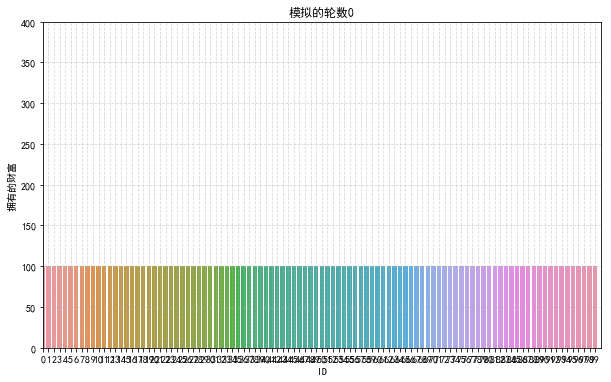

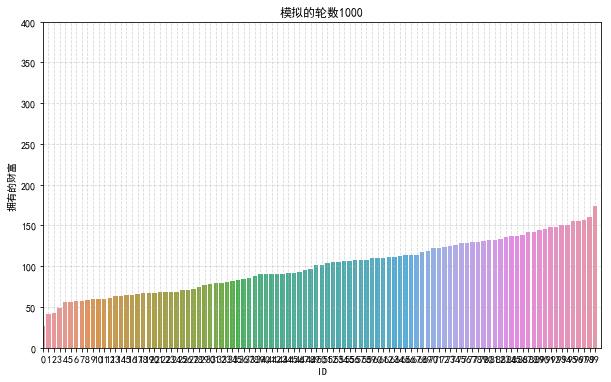

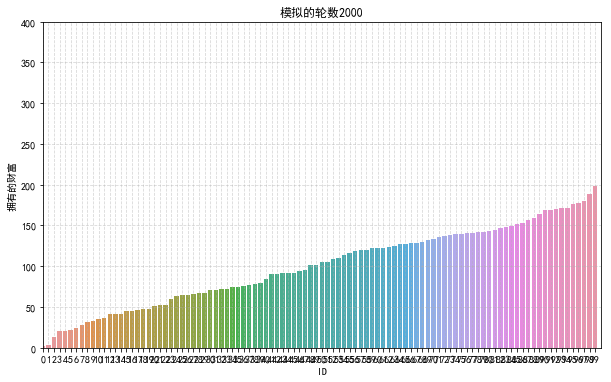

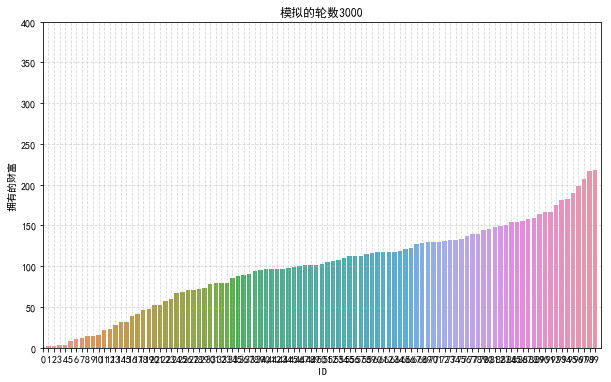

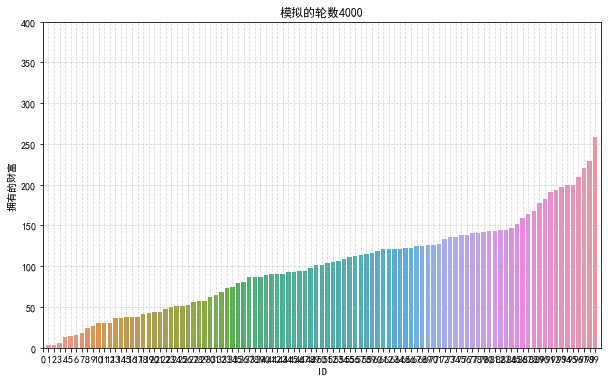

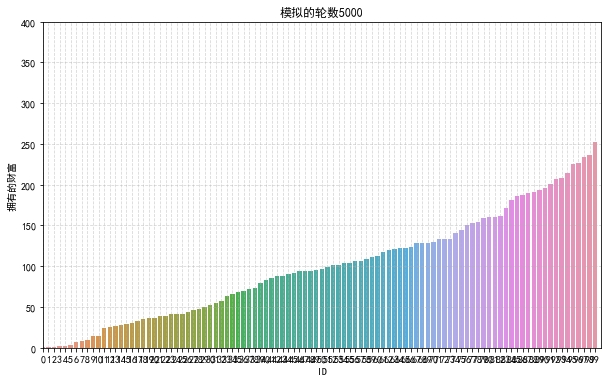

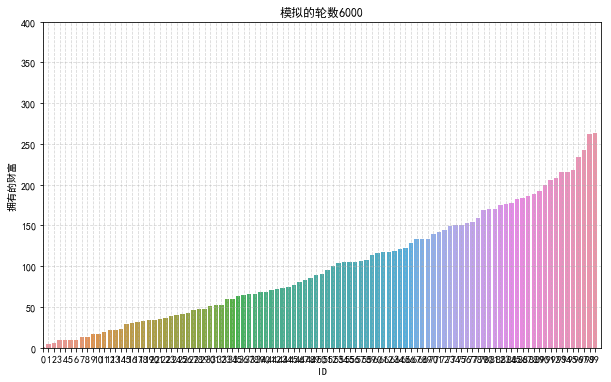

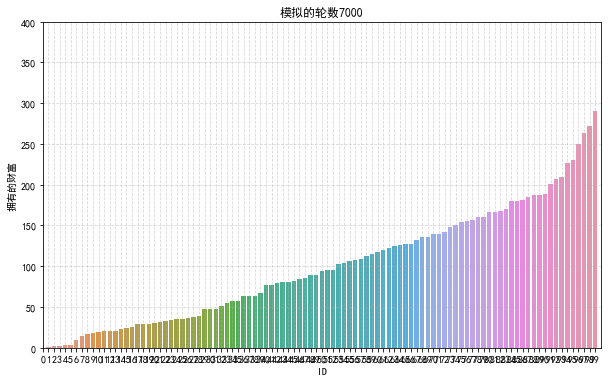

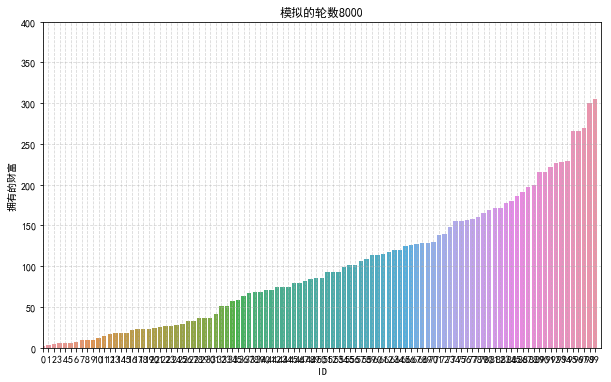

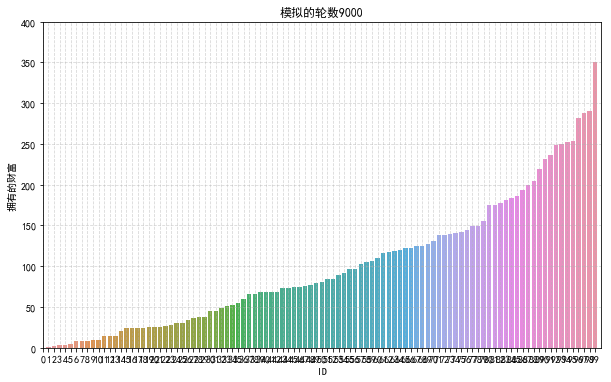

In [3]:
def draw(data, start, end, length):
    for n in list(range(start, end,length)):
        datai =data.iloc[n].sort_values().reset_index()[n]
        plt.figure(figsize=(10,6))
        sns.barplot(datai.index, datai.values)
        plt.xlim((0,100))
        plt.ylim((0,400))
        plt.title('模拟的轮数%s' % n)
        plt.xlabel('ID') 
        plt.ylabel('拥有的财富')
        plt.grid(alpha=0.5, linestyle='--')

draw(game1_result, 0,10000,1000)

## 结论:可以看出在有社会帮助的情况下，每个人起码能保持最低收入，可能为0但不会负债严重。当然相对的，也会有人一直盈利导致财富远远超过其他人

# 情况二:然后看看比较现实的情况，每个人有不同的收益概率，而且没钱了为了维持日常生活还是会支出

In [13]:
# 初始化参数

#一共分配（游戏）2000次
N=2000


#投机者（负债但是仍然消费）20人
tj_id=[i for i in range(20)]
tj=pd.DataFrame([0 for i in range(20)],index=tj_id)

#努力工作者（可能现在财富并不多拥有60，但是获得利益的概率多1%）占大多数50人
nl_id=[i for i in range(20,70)]
nl=pd.DataFrame([60 for i in range(50)],index=nl_id)

#投资者（本身就很富有拥有100，而且很会投资，每次获得收益概率多3%）5人
tz_id=[i for i in range(70,75)]
tz=pd.DataFrame([100 for i in range(5)],index=tz_id)


#剩下就是知识进步（现在可能很不富有，拥有30，但是有知识有10%的概率获得利益）25人
zs_id=[i for i in range(75,100)]
zs=pd.DataFrame([30 for i in range(25)],index=zs_id)

In [14]:
# 将上面定义的人群合并起来
person=pd.concat([tj,nl,tz,zs])
person.head()

,0
0,0
1,0
2,0
3,0
4,0


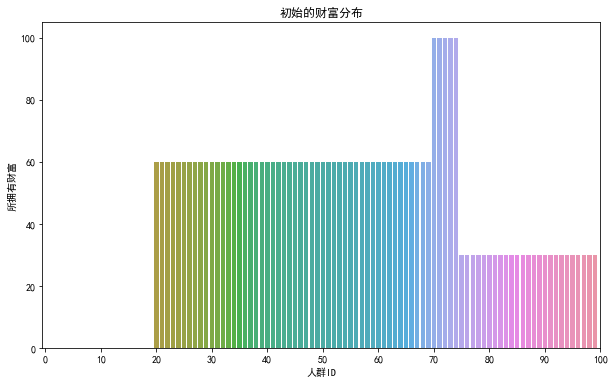

In [16]:
person.index.name='id'
person.columns=['money']

plt.figure(figsize=(10,6))
sns.barplot(person.index,person.money)
plt.title("初始的财富分布")
plt.xlabel("人群ID")
plt.xticks(np.arange(0,101,10),np.arange(0,101,10)) 
plt.ylabel("所拥有财富")
plt.show()

In [7]:
#定义游戏(分配规则)

#得到钱的机会(也就是收益概率不同)
chance=np.concatenate((np.array([0.008425]*20),np.array([0.0101]*50),np.array([0.0103]*5),np.array([0.011]*25)))
#0.01*0.01+0.01
#得到失去钱的id
def get_fromid(id_from):
    id_to=np.random.choice(a=np.arange(100),size=1,replace=False,p=chance)
    #不能自己给自己钱
    if id_to==id_from:
        id_to=get_fromid(id_from)
    return id_to

def game2(data,time):
    for i in range(time):
        if i%500==0:
            print(f"正在模拟第{i}轮")
        for id_from in range(0,len(data)):
            id_to=get_fromid(id_from)
            data['money'][id_from]-=1
            data['money'][id_to]+=1
    return data

final=game2(person,N)

正在模拟第0轮
正在模拟第500轮
正在模拟第1000轮
正在模拟第1500轮


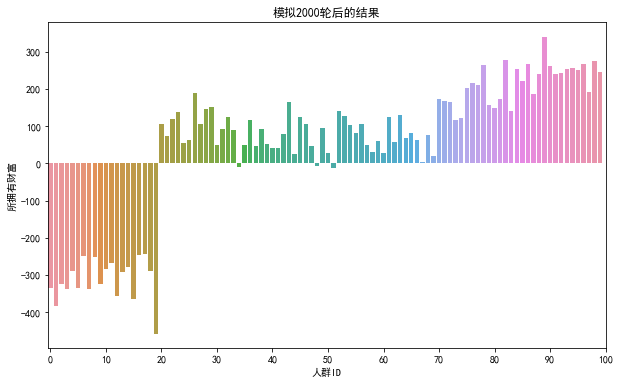

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(final.index,final.money)
plt.title("模拟2000轮后的结果")
plt.xlabel("人群ID")
plt.xticks(np.arange(0,101,10),np.arange(0,101,10)) 
plt.ylabel("所拥有财富")
plt.show()

## 结论:当你本身没有钱的时候，仍然参与社会活动那么只会让负债情况更严重；而努力工作的奋斗者们大多数可以获得更多财富，当然也有的会负债，就像有些人再怎么奋斗也还是无法改变现状；再来看看投资者资本家们,只会越来越富有；而当初那些穷小子但是能力非凡的人最后的财富却可以赶上甚至超过资本家

# 情况三:当然也有投机者中也在默默努力的，他们相应的收益概率也会提高，再模拟试试
我取10-19这10个投机者作为努力型投机者

In [9]:
#得到钱的机会(也就是收益概率不同)
chance2=np.concatenate((np.array([0.00675]*10),np.array([0.0101]*10),np.array([0.0101]*50),np.array([0.0103]*5),np.array([0.011]*25)))

#得到失去钱的id
def get_fromid2(id_from):
    id_to=np.random.choice(a=np.arange(100),size=1,replace=False,p=chance2)
    #不能自己给自己钱
    if id_to==id_from:
        id_to=get_fromid2(id_from)
    return id_to

def game3(data,time):
    for i in range(time):
        if i%500==0:
            print(f"正在模拟第{i}轮")
        for id_from in range(0,len(data)):
            id_to=get_fromid2(id_from)
            data['money'][id_from]-=1
            data['money'][id_to]+=1
    return data

final2=game3(person,N)

正在模拟第0轮
正在模拟第500轮
正在模拟第1000轮
正在模拟第1500轮


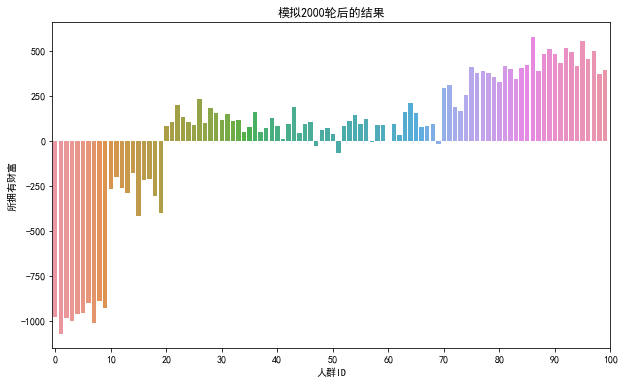

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(final2.index,final2.money)
plt.title("模拟2000轮后的结果")
plt.xlabel("人群ID")
plt.xticks(np.arange(0,101,10),np.arange(0,101,10)) 
plt.ylabel("所拥有财富")
plt.show()

## 结论：从上面的对比可以看出，当负债仍然努力的话，会减少负债的程度；当然如果足够努力（提高收钱的概率），也是有可能变成正资产的。

# 最后呢，我想从一次完整的数据分析，数据挖掘的角度来看待这次问题。
+ 首先呢，数据分析第一步是数据的采集（爬虫、公开数据、任务数据……）
+ 拿到数据后先想清楚我们需要分析什么，明确大致的分析方向
+ 然后是数据清洗，数据预处理工作，为了保证数据的合理性以及有效性
+ 对于大多数情况下我们还会切分数据集，根据具体问题构建数学模型或者各种算法去分析（利用机器学习算法、深度学习网络、遗传算法……），最后得到一个既不欠拟合也不过拟合，具有良好鲁棒性的模型
+ 最后得到的结果我们会进行可视化，可以让人直观的看到分析的过程以及结果，得到相应的结论
+ 有的时候为了总结更清楚，还需要写分析报表、分析ppt

那就我们这次的作业来看，数据呢是自己定义的，所以也不用清洗。建模部分也没有用到什么其他的模型，主要就是蒙特卡罗方法，利用概率和大量实验去贴近现实情况。这个方法从简单的求pi值到之前B站其他up主模拟新冠病毒感染人的传播情况，几乎所有概率问题都能用它通过大量实验得到结果；当然最后每一种模型下由相应的可视化图都给出了自己的结论，至于报表之类的嘛老师没要求，所以我也不去做啦。（偷懒嘻嘻嘻）